# Useful Information

## Standardization

Standardization is a common preprocessing step in training deep learning models, including those for medical image analysis. This process is performed by subtracting the mean and dividing by the standard deviation for each pixel or voxel in the image.

Why? Including but not limited to the following:

Stabilizing Training: bring the pixel values into a consistent range, which can lead to faster convergence during training.

Gradient Descent: having input data with a consistent scale can result in more stable and efficient updates

Better Initialization: making it easier for the network to learn effectively from the beginning.

## Data Augmentation

Data Augmentation is a technique used to artificially increase the diversity and quantity of the training dataset by applying various transformations to the original data. This process generates new examples that are similar to the original ones but have variations in terms of rotation, scaling, flipping, cropping, noise, and other factors.

Benefits:

Increased dataset size.

Improved Generalization.

Reduced Overfitting.

Realistic Scenarios.

Enhanced Feature Learning.

Reduction of Bias.

More Efficient Training.

# Import Libraries

In [73]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [74]:
print(torch.cuda.is_available())

True


# Load Preprocessed Data

In [75]:
def load_file(path):
    return np.load(path).astype(np.float32)

Load the computed mean and standard deviation from the preprocessing notebook

In [76]:
mean_std = load_file("../data/interim/variables/mean_std.npy")
mean_std

array([0.49039626, 0.2479507 ], dtype=float32)

Create a data transform pipeline

In [77]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_std[0], mean_std[1]), # Standardization
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)), # Data Augmentation
        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)), # Data Augmentation
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_std[0], mean_std[1]),
    ]
)

In [78]:
train_dataset = torchvision.datasets.DatasetFolder(
    root="../data/interim/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    root="../data/interim/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms
)

In [79]:
def visualize(data, row=2, column=2, figsize=(9, 9)):
  fig, ax = plt.subplots(row, column, figsize=figsize)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  for i in range(row):
    for j in range(column):
      index = np.random.randint(0, 24000)
      x_ray, label = data[index]
      ax[i][j].imshow(x_ray[0], cmap="bone") # torchvision automatically append general information so we need to indexing x_ray
      if label == 0:
        ax[i][j].set_title(f"Negative")
      else:
        ax[i][j].set_title(f"Positive")
      index += 1

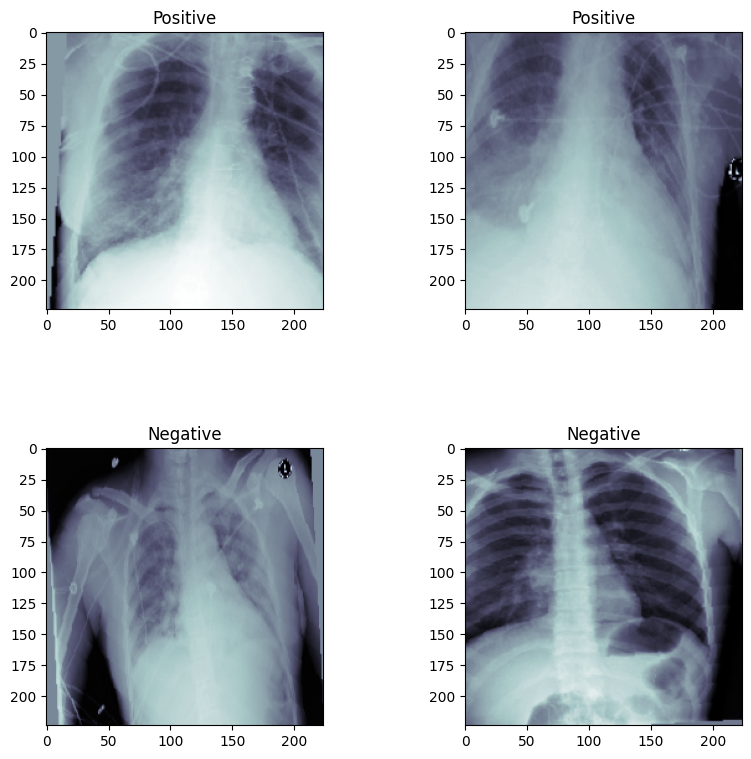

In [80]:
visualize(train_dataset)

Create data loaders

In [81]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: ../data/interim/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49039626121520996, std=0.2479507029056549)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
           )

In [82]:
os.cpu_count() # Check number of cpu cores your pc has

12

In [83]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

In [84]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407], dtype=int64))

We can see that the dataset is imbalanced

# Train Model

In [85]:
# We will use ResNet18 CNN
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        # Change number of input channel from 3 (default of ResNet18) to 1
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change number of output for the fully connected later from 1000 to 1 (Because we only need to determine if there is Pneumonia or not)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

        self.save_hyperparameters()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log("Train Loss",  loss)
        self.log("Step Train Accuracy", self.train_acc(torch.sigmoid(pred), label.int()))

        return loss
    
    def on_train_epoch_end(self):
        self.log("Train Accurary", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log("Validate Loss",  loss)
        self.log("Step Validate Accuracy", self.val_acc(torch.sigmoid(pred), label.int()))

    def on_validation_epoch_end(self):
        self.log("Validate Accurary", self.val_acc.compute())
    
    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
model = PneumoniaModel()

In [88]:
torch.set_float32_matmul_precision("medium")

In [89]:
MODEL_CHECKPOINT_PATH = Path("../models/checkpoint")
MODEL_CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor="Validate Accurary",
    save_top_k=10,
    mode="max",
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=-1,
    logger=TensorBoardLogger(save_dir="../reports/logs"),
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=35,
    default_root_dir=MODEL_CHECKPOINT_PATH
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Epoch 34: 100%|██████████| 375/375 [02:25<00:00,  2.57it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 375/375 [02:26<00:00,  2.56it/s, v_num=6]
